# Validation auROC histogram and posterior probability distribution

John Curtin & Claire Punturieri  
October 17, 2024

# Housekeeping

## Code status

Complete for use in GPS study as of 10/2024.

## Notes

Generates a median auROC histogram for best model configuration.

# Set Up

## Set Up Environment

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
model <- params$model
algorithms <- params$algorithms
version <- params$version


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))


# Generate performance metric plot

In [ ]:
# probs_local <- read_rds(file.path(path_models, str_c("inner_preds_", 
#                                             window, "_", version, "_", 
#                                             cv, "_", model, ".rds"))) |>
#    mutate(prob = prob_logi) |> 
# #   #pivot_longer(cols = starts_with("prob"), 
# #                #names_to = "method", 
# #                #values_to = ".pred_Lapse") |>
#    glimpse()

probs <- read_csv(here::here(path_models, str_c("best_config_",
                                             version, "_",
                                             cv, "_", model, ".csv"))) |> 
  glimpse()


Rows: 300 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): algorithm, feature_set, resample
dbl (13): config_num, outer_split_num, inner_split_num, hp1, hp2, hp3, sens,...
lgl  (1): split_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 300
Columns: 17
$ config_num      <dbl> 150262, 152110, 153958, 155806, 15358, 157654, 159502,…
$ split_num       <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA…
$ outer_split_num <dbl> 9, 9, 9, 9, 1, 9, 9, 9, 9, 9, 10, 10, 10, 10, 1, 10, 1…
$ inner_split_num <dbl> 2, 3, 4, 5, 9, 6, 7, 8, 9, 10, 1, 2, 3, 4, 10, 5, 6, 7…
$ algorithm       <chr> "xgboost", "xgboost", "xgboost", "xgboost", "xgboost",…
$ feature_set     <chr> "context_affect_rawdiff", "context_affect_rawdiff", "c…
$ hp1             <dbl> 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, …
$ hp2             <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ hp3             <dbl> 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40…
$ resample        <chr> "up_1", "up_1", "up_1", "up_1", "up_1", "up_1", "up_1"…
$ sens            <dbl> 0.7857143, 0.4626866, 0.7564103, 0.6323529, 0.3673469,…
$ spec            <dbl> 0.7149758, 0.7260556, 0.6787679, 0.7945652, 0.7647658,…
$ ppv             

Calculate auROC in each fold

In [ ]:
# auROCs <- probs |>
#   group_by(outer_split_num, inner_split_num) |>
#   summarize(auROC = roc_auc_vec(truth = label, estimate = prob),
#             .groups = "drop")
# 
# auROCs |> pull(auROC) |> median()


Generate plot across all *inner* folds.

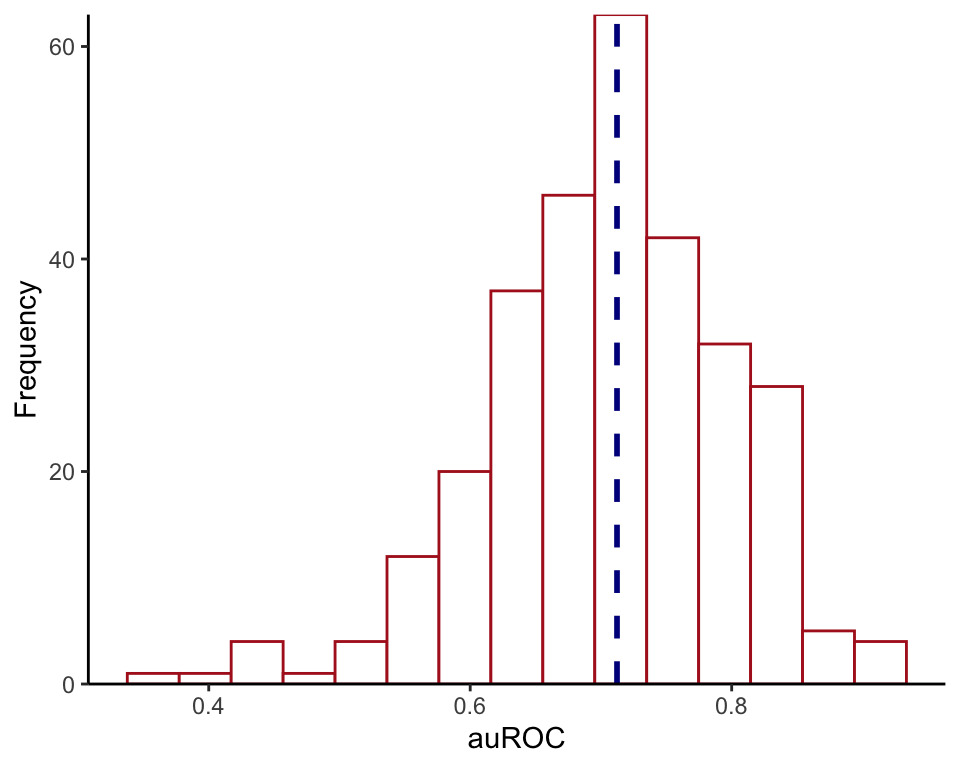

In [ ]:

# auROCs |> 
#   ggplot(aes(x = auROC)) +
#   geom_histogram(bins = 10, fill = c("#af1f21")) +
#   geom_vline(xintercept = median(auROCs$auROC), color = c("#f29c96"), lwd = 1, linetype="longdash") +
#   labs(x = "auROC", y = "Frequency")
probs |> 
  ggplot(aes(x = roc_auc)) +
  geom_histogram(bins = 15, color = c("#af1f21"), fill = "white") +
  #geom_step(bins = 10, fill = c("#af1f21")) +
  #stat_bin(geom="step", bins = 10, color = c("#af1f21"), lwd = 1) +
  geom_vline(xintercept = median(probs$roc_auc), color = c("darkblue"), lwd = 1, linetype="dashed") +
  scale_y_continuous(expand = c(0,0)) +
  labs(x = "auROC", y = "Frequency")


# Posteriors

In [ ]:
# from ?perf_mod()
# Repeated CV (id = repeat, id2 = fold within repeat)
# with a common variance:  statistic ~ model + (model | id2/id)

if(file.exists(here::here(path_models, str_c("pp_",
                                    version, "_",
                                    cv, "_", model, ".rds")))) {
  
  message("Model exists! Loading in...")
  
  pp <- read_rds(here::here(path_models, str_c("pp_",
                                    version, "_",
                                    cv, "_", model, ".rds")))
} else {
  
    message("Model does not exist! Running and saving out...")
  
  set.seed(101)
  
  pp <- probs |> #auROCs |>
    select(outer_split_num, inner_split_num, roc_auc) |> 
           #auROC) |> 
    rename(id = outer_split_num,
           id2 = inner_split_num) |> 
    perf_mod(formula = statistic ~ 1 + (1 | id/id2),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             iter = 13000, chains = 4,
             adapt_delta = .99999999,
             # cores = 4, seed = 12345,
             family = gaussian)  


  pp |> write_rds(here::here(path_models, str_c("pp_",
                                                version, "_",
                                                cv, "_", model, ".rds")))
}


Model exists! Loading in...

Posterior graph as density plot

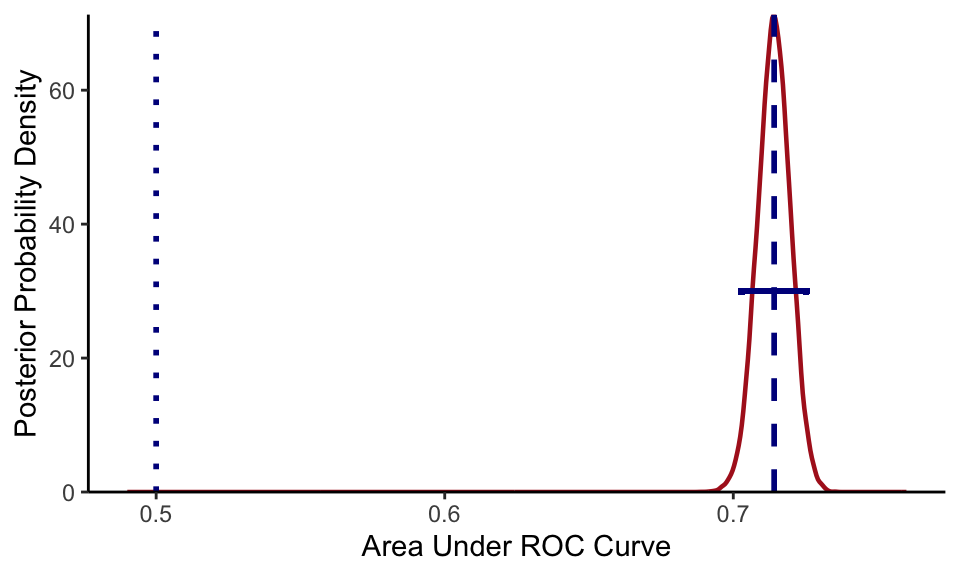

In [ ]:

pp_tidy <- pp |> 
  tidy(seed = 123)

q <- c(0.025, 0.5, 0.975)

ci_day <- pp_tidy |> 
  summarize(median = quantile(posterior, probs = q[2]),
            lower = quantile(posterior, probs = q[1]), 
            upper = quantile(posterior, probs = q[3])) |> 
  mutate(y = 30)

pp_tidy |> 
  ggplot(aes(x = posterior)) + 
  geom_density(color = c("#af1f21"), fill = "white", alpha = 1, lwd = .8) +
  #geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), color = c("#af1f21"),
                #data = ci_day, lwd = 1) +
  geom_errorbar(aes(y = ci_day$y, xmin = ci_day$lower, xmax = ci_day$upper), color = c("darkblue"), lwd = 1) +
  geom_vline(xintercept = ci_day$median, color = c("darkblue"), lwd = 1, linetype="dashed") +
  geom_vline(xintercept = .5, color = "darkblue", lwd = 1, linetype="dotted") +
  scale_x_continuous(limits=c(0.49,.76)) +
  scale_y_continuous(expand = c(0,0)) +
  ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve")


In [ ]:
pp_tidy <- pp |> 
  tidy(seed = 123) |> 
  write_csv(here::here("objects", "pp_tidy.csv"))

pp_tidy |> 
 summarize(prob = mean(posterior > .5)) 


# A tibble: 1 × 1
   prob
  <dbl>
1     1